In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway
from statannotations.Annotator import Annotator
from itertools import combinations
import sys
sys.path.append('../scripts') 
from functions import *
from config import nutrient_info, conversion_factors

In [3]:
df_food = pd.read_csv("../data/df_food_filtered_with_food_group.csv",index_col=0)
with open("../data/df_food_openfoodfacts_merged.pkl", "rb") as f:
    df_food_openfoodfacts = pickle.load(f, encoding="latin1")

C:\Users\Sophie\AppData\Local\Temp\ipykernel_3064\2857174756.py:1: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food = pd.read_csv("../data/df_food_filtered_with_food_group.csv",index_col=0)


In [4]:
df_food = df_food[df_food["eaten_quantity_in_gram"] > 0]
df_food = df_food[df_food["energy_kcal_eaten"] > 0]

In [5]:
qualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'qualifying'}
disqualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'disqualifying'}

In [6]:
df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')

C:\Users\Sophie\AppData\Local\Temp\ipykernel_3064\2711278687.py:1: DtypeWarning: Columns (1,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')


In [7]:
df_food_scaled[['QI', 'DI','NB', 'combined_name', 'food_group']].groupby('food_group').median(numeric_only=True).sort_values('QI')

,QI,DI,NB
food_group,,,
sweetened_beverages,0.030110,0.664300,3.010960
alcoholic_beverages,0.040134,0.007668,4.013378
soups_sauces_condiments,0.078738,1.068889,5.263158
salty_snacks,0.132909,0.526942,10.526316
cooked_grains_pasta,0.142698,0.517566,9.851552
sweets_desserts,0.165655,0.863140,13.890302
butter_margarine_spreads,0.224674,1.837749,11.362562
vegetable_fruit_juices,0.225528,0.626646,8.852694
vegetable_oils,0.244127,0.694173,5.526527


In [8]:
df_vegetable = df_food_scaled[df_food_scaled['food_group'] == 'vegetables']

In [9]:
df_vegetable.drop_duplicates('combined_name')

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,protein_eaten_ratio_scaled,fat_eaten_ratio_scaled,fatty_acids_saturated_eaten_ratio_scaled,cholesterol_eaten_ratio_scaled,sugar_eaten_ratio_scaled,sodium_eaten_ratio_scaled,salt_eaten_ratio_scaled,QI,DI,NB
90,50,0,4055,40.0,g,k3pnhy,2019-02-14 18:57:30,60,1,vegetables_fruits,...,1.449275,0.044984,0.000000,0.0,2.947368,0.847953,0.000000,1.767673,0.640051,73.609462
808,116,0,302297,40.0,g,2td76w,2021-11-18 18:11:53,60,1,vegetables_fruits,...,4.202899,0.341880,0.303030,0.0,1.173333,0.305556,0.000000,8.303348,0.353967,84.210526
1066,143,0,261362,100.0,g,dradpm,2021-09-06 10:46:40,120,1,vegetables_fruits,...,0.954401,0.187617,0.000000,0.0,2.770732,0.508130,0.000000,1.974445,0.577747,79.506118
1724,148,0,122140,150.0,g,g5qdh7,2020-05-21 10:40:59,120,1,vegetables_fruits,...,2.717391,0.160256,0.000000,0.0,1.600000,5.208333,0.000000,4.448798,1.161432,84.210526
1725,150,0,209797,40.0,g,jb3nq3,2021-04-18 17:09:04,120,1,vegetables_fruits,...,2.318841,0.256410,0.000000,0.0,1.066667,2.361111,0.000000,3.805110,0.614031,84.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244036,33127,7627534181055,385720,52.0,g,kgbtut,2022-09-20 16:42:32,120,0,unclassified,...,1.234568,0.633112,0.561167,0.0,1.362963,0.000000,2.057613,0.215724,0.769143,10.526316
244077,33189,7613312295588,388048,250.0,g,kgbtut,2022-09-26 16:53:22,120,0,unclassified,...,1.708075,0.457875,0.000000,0.0,0.800000,0.000000,7.738095,0.495914,1.499328,10.526316
244304,33518,7627534612115,397015,200.0,g,wjtpa5,2022-11-06 21:49:57,60,0,unclassified,...,4.347826,0.000000,0.000000,0.0,1.333333,0.000000,0.000000,0.720061,0.222222,10.526316
244455,46071,7613312273760,406384,250.0,g,48wbxy,2022-12-08 11:09:58,60,0,unclassified,...,2.879729,0.432900,0.236128,0.0,0.644156,0.000000,1.991342,0.397634,0.550754,10.526316


# Vegetables with QI > 10

In [10]:
high_qi_vegetable = df_vegetable[df_vegetable['QI'] > 10].drop_duplicates('combined_name').sort_values('QI', ascending=False)

In [11]:
high_qi_vegetable[['combined_name', 'eaten_quantity', 'QI', 'DI', 'NB']]

,combined_name,eaten_quantity,QI,DI,NB
228311,Coop Naturaplan Betty Bossi Organic mung bean ...,100.0,41.475964,1.335664,78.947368
227445,Epinards,50.0,11.494326,0.613869,84.210526
3125,"Spinach, raw",70.0,11.494326,0.613869,84.210526
231814,"Coop - Naturaplan - Alfalfa, Rucola, Sprossen",80.0,11.207810,0.248538,82.640813
6848,"Bell pepper, green, stewed, without addition o...",60.0,10.752978,0.446409,77.170023
1815,"Chanterelle, stewed, without addition of fat, ...",80.0,10.622654,0.194501,86.032389


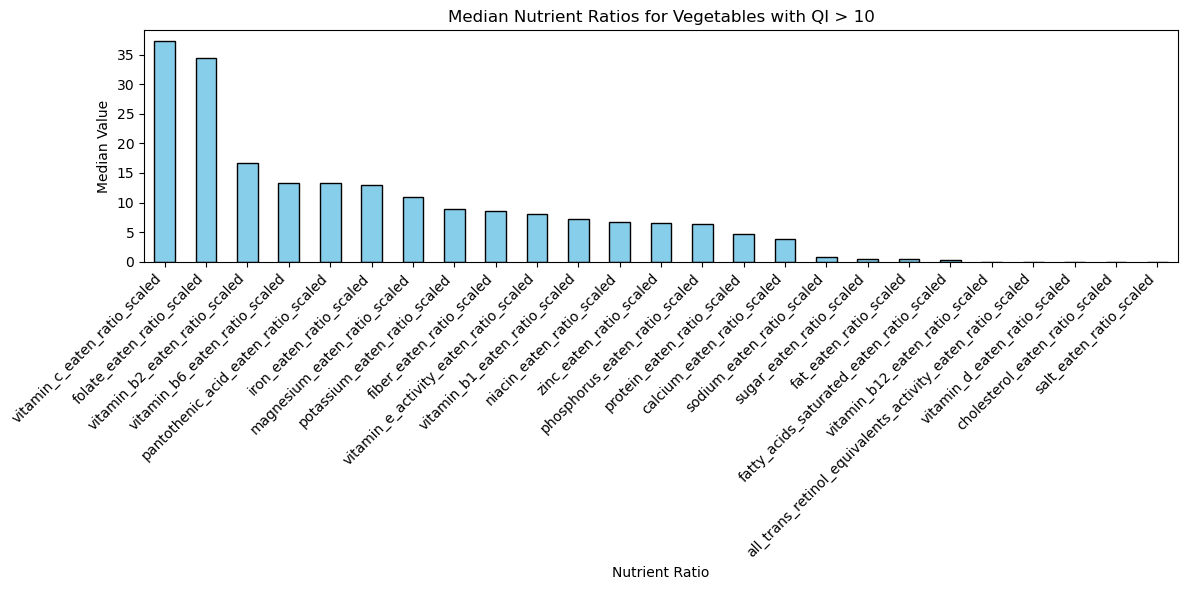

In [12]:
ratio_cols = [i for i in high_qi_vegetable.columns if '_ratio_scaled' in i]
median_ratios = high_qi_vegetable[ratio_cols].median().sort_values(ascending=False)


plt.figure(figsize=(12, 6))
median_ratios.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Median Nutrient Ratios for Vegetables with QI > 10")
plt.xlabel("Nutrient Ratio")
plt.ylabel("Median Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
df_corr = high_qi_vegetable[ratio_cols + ['QI']]
corr = df_corr.corr()['QI']
corr.sort_values(ascending=True)

fat_eaten_ratio_scaled                                      -0.616166
fiber_eaten_ratio_scaled                                    -0.504160
vitamin_c_eaten_ratio_scaled                                -0.424557
sodium_eaten_ratio_scaled                                   -0.374036
vitamin_d_eaten_ratio_scaled                                -0.219341
niacin_eaten_ratio_scaled                                   -0.077740
protein_eaten_ratio_scaled                                  -0.071684
calcium_eaten_ratio_scaled                                   0.006951
folate_eaten_ratio_scaled                                    0.050470
pantothenic_acid_eaten_ratio_scaled                          0.185189
sugar_eaten_ratio_scaled                                     0.642836
iron_eaten_ratio_scaled                                      0.657740
potassium_eaten_ratio_scaled                                 0.834234
vitamin_b2_eaten_ratio_scaled                                0.884644
salt_eaten_ratio_sca

As we can see, the beta carotene is the micronutrient with the most correlation with QI. Magnesium, calcium, folate and vitamin b1 should also be factor to this change

## Beta carotene

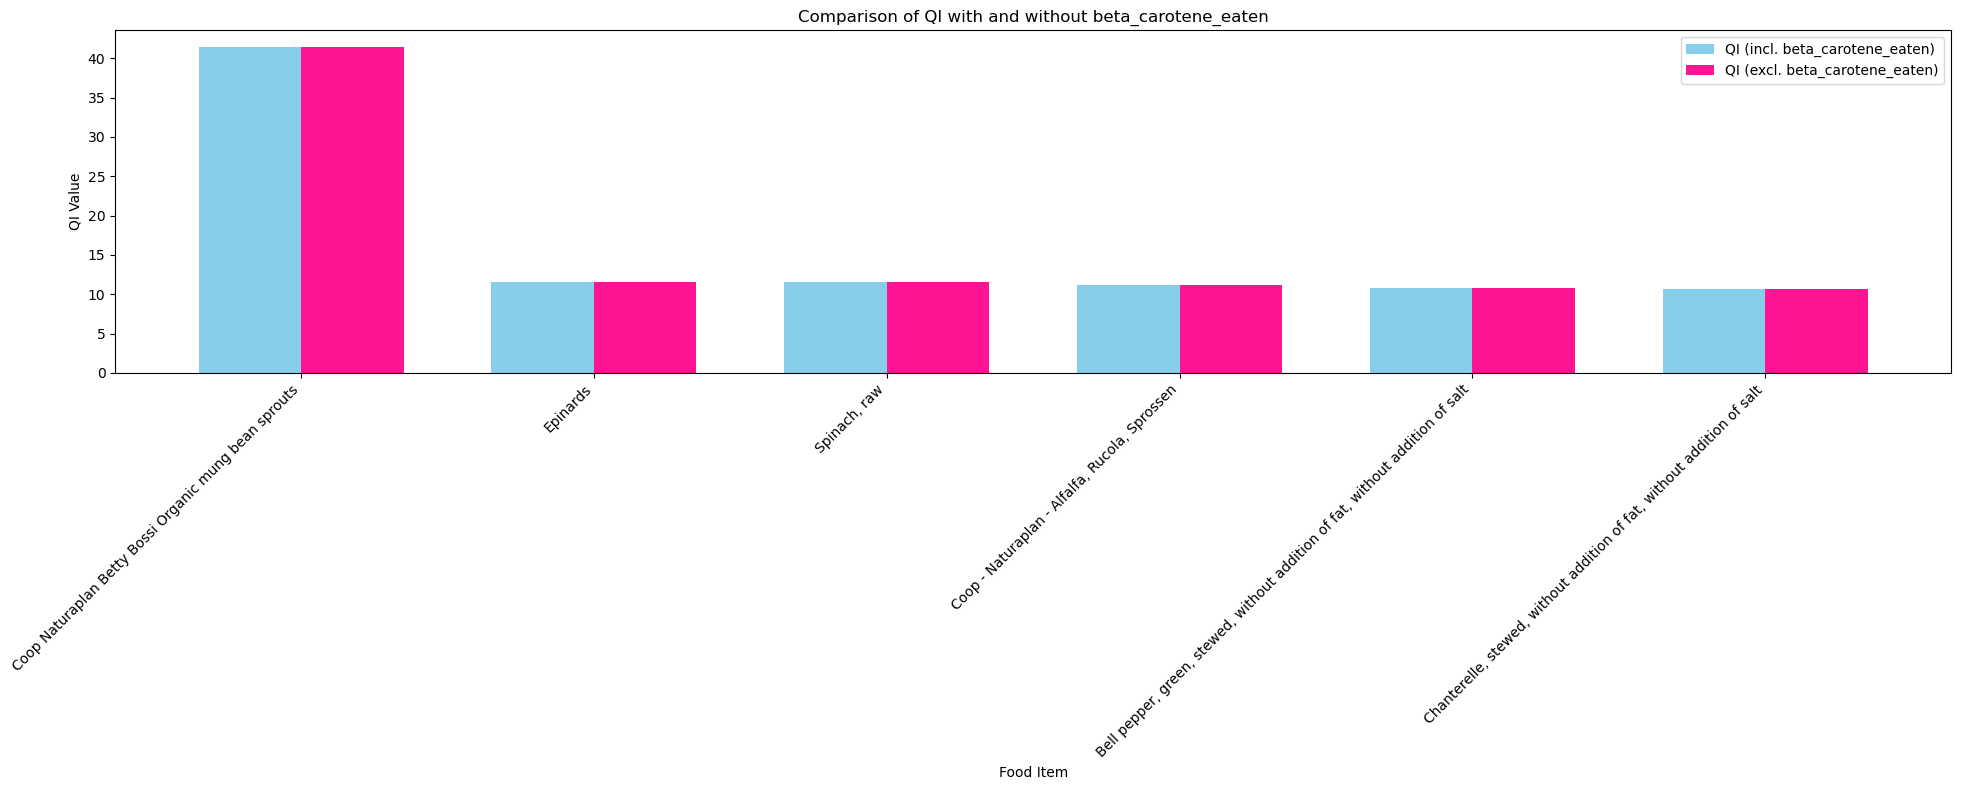

,combined_name,QI,QI_excl_beta_carotene_eaten,QI_diff,QI_pct_change
228311,Coop Naturaplan Betty Bossi Organic mung bean ...,41.475964,41.475964,0.000000e+00,0.000000e+00
227445,Epinards,11.494326,11.494326,7.105427e-15,6.181683e-14
3125,"Spinach, raw",11.494326,11.494326,0.000000e+00,0.000000e+00
231814,"Coop - Naturaplan - Alfalfa, Rucola, Sprossen",11.207810,11.207810,5.329071e-15,4.754783e-14
6848,"Bell pepper, green, stewed, without addition o...",10.752978,10.752978,1.776357e-15,1.651967e-14
1815,"Chanterelle, stewed, without addition of fat, ...",10.622654,10.622654,0.000000e+00,0.000000e+00


In [14]:
df_vegetable_beta_carotene = compare_qi_excluding_nutrient(df=high_qi_vegetable, nutrient_to_exclude='beta_carotene_eaten', qualifying_nutrients=qualifying_nutrients)

df_vegetable_beta_carotene

Overall, beta-carotene is the micronutrient that most strongly influences the QI value. I tested all the other qualifying nutrients, and they only slightly changed the value, remained the same, or even increased the QI. I will perform a more detailed analysis on specific food items where the elimination of beta-carotene alone was not sufficient.

### Aberrant values analysis

In [15]:
high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Coop Naturaplan Betty Bossi Organic mung bean sprouts'][[i for i in high_qi_vegetable.columns if '_ratio_scaled' in i]].T

,228311
folate_eaten_ratio_scaled,27.500000
niacin_eaten_ratio_scaled,9.230769
pantothenic_acid_eaten_ratio_scaled,23.076923
vitamin_b2_eaten_ratio_scaled,41.958042
vitamin_b1_eaten_ratio_scaled,147.435897
all_trans_retinol_equivalents_activity_eaten_ratio_scaled,0.000000
vitamin_b12_eaten_ratio_scaled,0.000000
vitamin_b6_eaten_ratio_scaled,94.674556
vitamin_c_eaten_ratio_scaled,0.000000
vitamin_d_eaten_ratio_scaled,0.000000


In [16]:
"""
row = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Coop Naturaplan Betty Bossi Organic mung bean sprouts'].iloc[0]

exclude_list = ['vitamin_b6_eaten', 'vitamin_b1_eaten', 'phospharus_eaten', 'zinc_eaten', 'magnesium_eaten', 'vitamin_b2_eaten']

qi_excl = compute_qi_excluding_multiple(row, qualifying_nutrients, exclude_list, scaling_factor=2000)
print(f"QI excluding {exclude_list}: {qi_excl:.2f}")"
"""

'\nrow = high_qi_vegetable[high_qi_vegetable[\'combined_name\'] == \'Coop Naturaplan Betty Bossi Organic mung bean sprouts\'].iloc[0]\n\nexclude_list = [\'vitamin_b6_eaten\', \'vitamin_b1_eaten\', \'phospharus_eaten\', \'zinc_eaten\', \'magnesium_eaten\', \'vitamin_b2_eaten\']\n\nqi_excl = compute_qi_excluding_multiple(row, qualifying_nutrients, exclude_list, scaling_factor=2000)\nprint(f"QI excluding {exclude_list}: {qi_excl:.2f}")"\n'

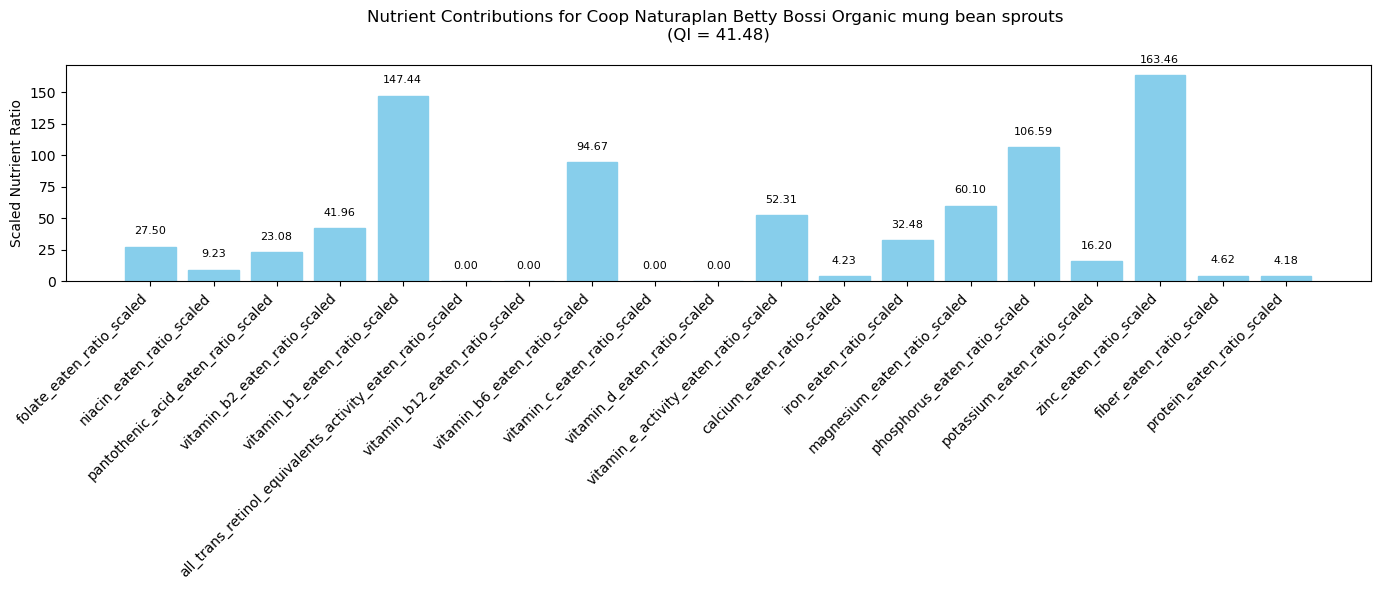

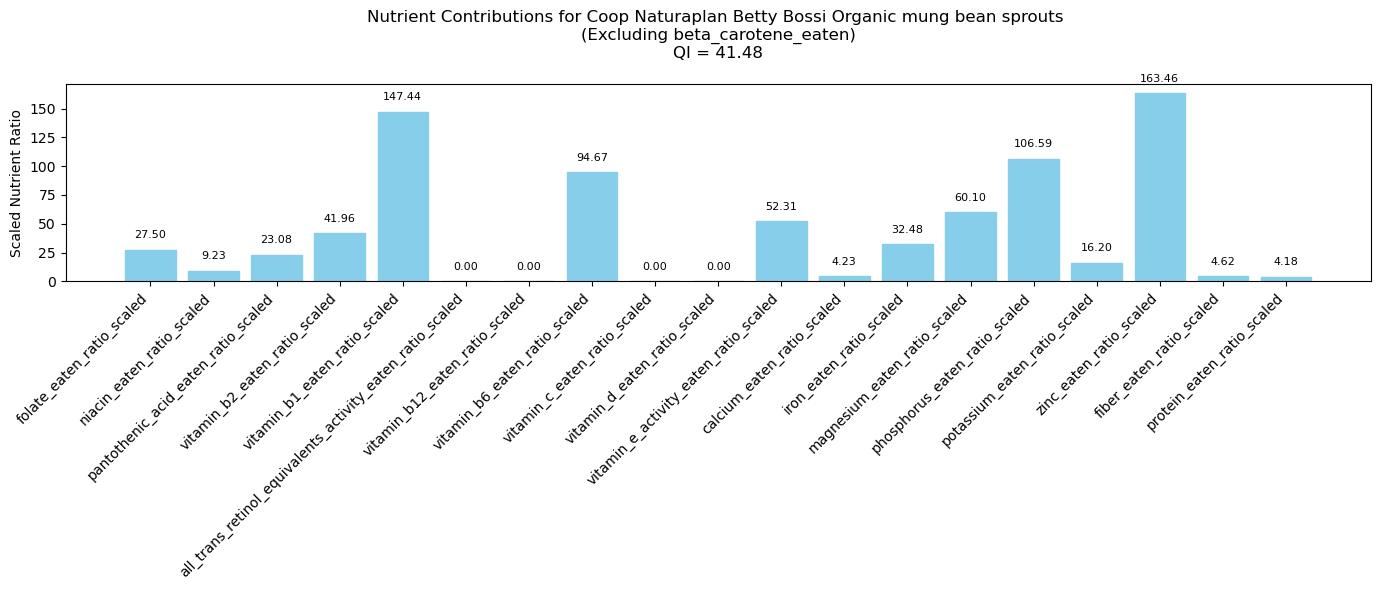

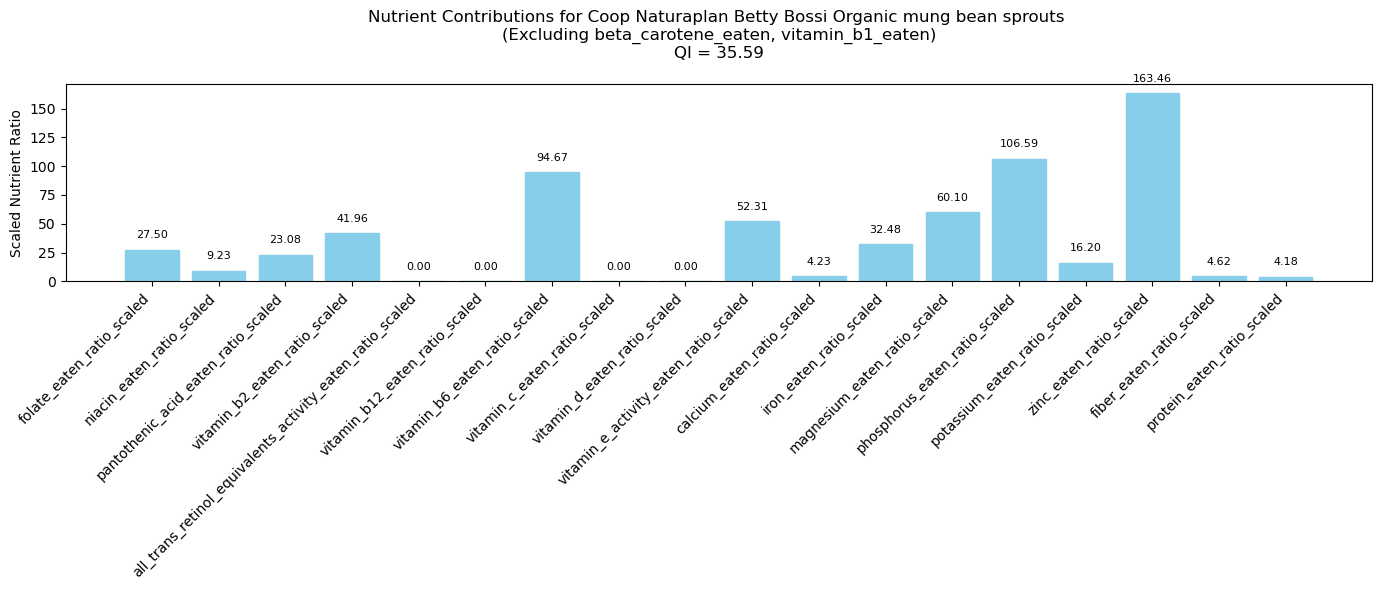

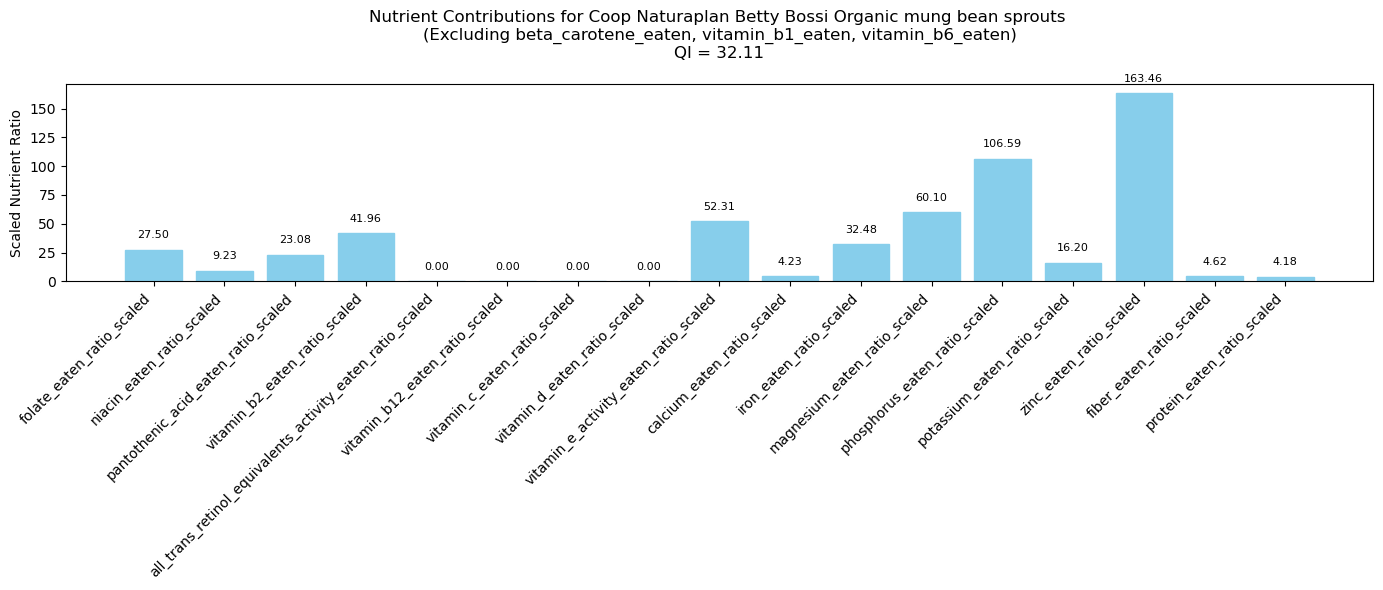

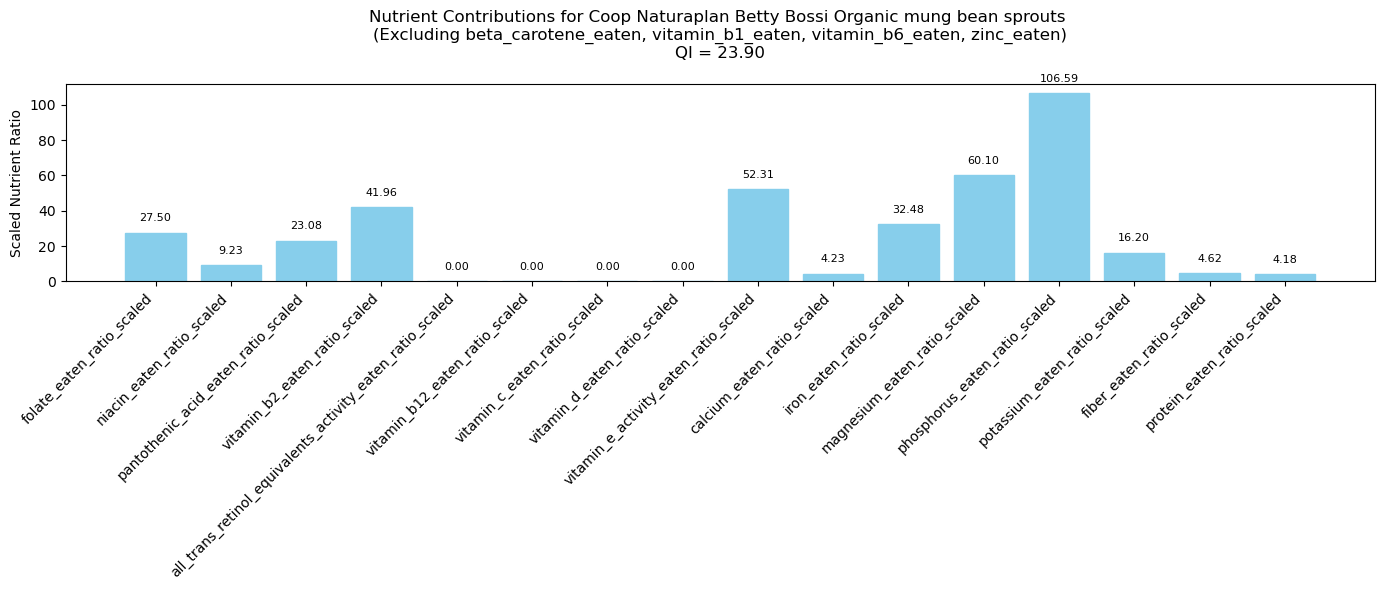

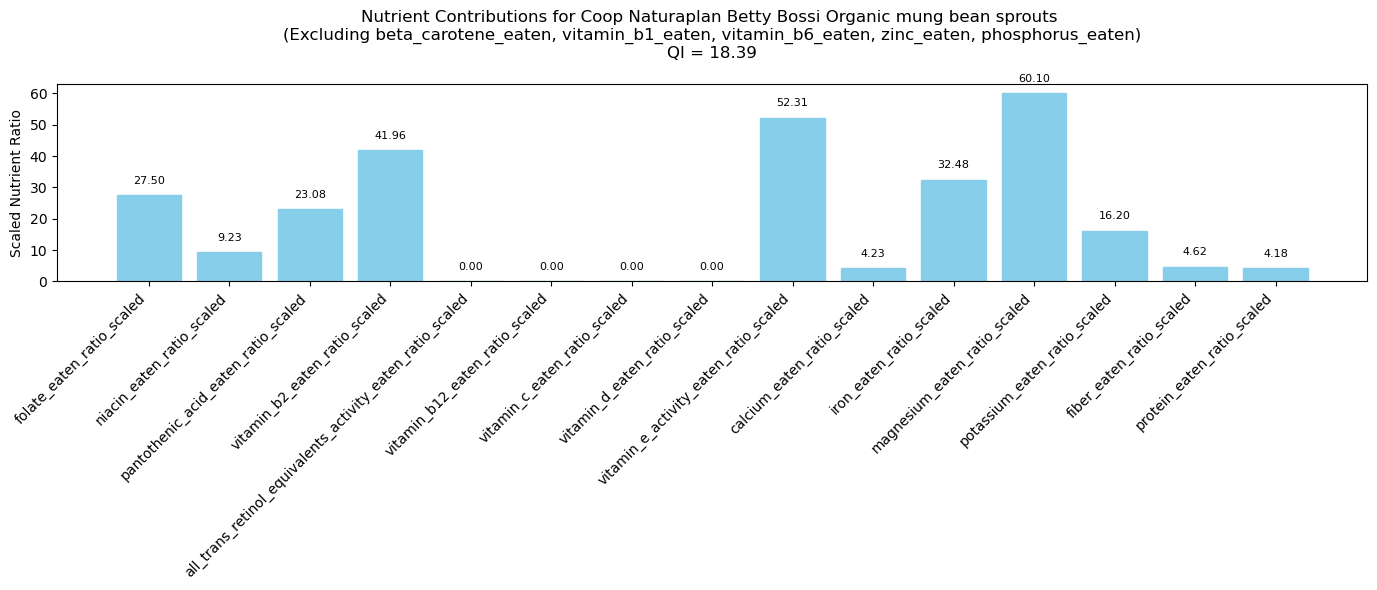

In [17]:
food_item = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Coop Naturaplan Betty Bossi Organic mung bean sprouts'].iloc[0]

plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients)
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten'])
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten', 'vitamin_b1_eaten'])
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten', 'vitamin_b1_eaten', 'vitamin_b6_eaten'])
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten', 'vitamin_b1_eaten', 'vitamin_b6_eaten', 'zinc_eaten'])
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten', 'vitamin_b1_eaten', 'vitamin_b6_eaten', 'zinc_eaten', 'phosphorus_eaten'])

In [18]:
food_item = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Coop Naturaplan Betty Bossi Organic mung bean sprouts'].iloc[0]
qi_including = food_item['QI']
results = []

for nutr in qualifying_nutrients:
    qi_excluding = compute_qi_excluding(food_item, qualifying_nutrients, exclude=nutr, scaling_factor=2000)
    abs_diff = qi_including - qi_excluding
    pct_diff = (abs_diff / qi_including) * 100
    results.append({
        'Nutrient Excluded': nutr,
        'QI (incl.)': qi_including,
        'QI (excl.)': qi_excluding,
        'Absolute Change': abs_diff,
        'Percent Change': pct_diff
    })


df_results = pd.DataFrame(results)
df_results.sort_values('Absolute Change', ascending=False)

,Nutrient Excluded,QI (incl.),QI (excl.),Absolute Change,Percent Change
16,zinc_eaten,41.475964,34.698987,6.776976,16.339527
4,vitamin_b1_eaten,41.475964,35.589301,5.886663,14.192950
14,phosphorus_eaten,41.475964,37.858328,3.617636,8.722246
7,vitamin_b6_eaten,41.475964,38.520487,2.955477,7.125759
13,magnesium_eaten,41.475964,40.441509,1.034455,2.494107
10,vitamin_e_activity_eaten,41.475964,40.874201,0.601763,1.450871
3,vitamin_b2_eaten,41.475964,41.449182,0.026782,0.064573
12,iron_eaten,41.475964,41.975816,-0.499852,-1.205160
0,folate_eaten,41.475964,42.252406,-0.776442,-1.872030
2,pantothenic_acid_eaten,41.475964,42.498133,-1.022169,-2.464485


In [19]:
high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Valenzi Eierschwämme klein'][[i for i in high_qi_vegetable.columns if '_ratio_scaled' in i]].T

""
folate_eaten_ratio_scaled
niacin_eaten_ratio_scaled
pantothenic_acid_eaten_ratio_scaled
vitamin_b2_eaten_ratio_scaled
vitamin_b1_eaten_ratio_scaled
all_trans_retinol_equivalents_activity_eaten_ratio_scaled
vitamin_b12_eaten_ratio_scaled
vitamin_b6_eaten_ratio_scaled
vitamin_c_eaten_ratio_scaled
vitamin_d_eaten_ratio_scaled


In [20]:
food_item = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Valenzi Eierschwämme klein'].iloc[0]

plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients)
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten', 'pantothenic_acid_eaten', 'niacin_eaten', 'iron_eaten'])

qi_including = food_item['QI']
results = []

for nutr in qualifying_nutrients:
    qi_excluding = compute_qi_excluding(food_item, qualifying_nutrients, exclude=nutr, scaling_factor=2000)
    abs_diff = qi_including - qi_excluding
    pct_diff = (abs_diff / qi_including) * 100
    results.append({
        'Nutrient Excluded': nutr,
        'QI (incl.)': qi_including,
        'QI (excl.)': qi_excluding,
        'Absolute Change': abs_diff,
        'Percent Change': pct_diff
    })


df_results = pd.DataFrame(results)
df_results.sort_values('Absolute Change', ascending=False)

IndexError: single positional indexer is out-of-bounds

In [ ]:
"""
row = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Valenzi Eierschwämme klein'].iloc[0]

exclude_list = ['beta_carotene_eaten', 'pantothenic_acid_eaten', 'niacin_eaten', 'iron_eaten']

qi_excl = compute_qi_excluding_multiple(row, qualifying_nutrients, exclude_list, scaling_factor=2000)
print(f"QI excluding {exclude_list}: {qi_excl:.2f}")"
"""

'\nrow = high_qi_vegetable[high_qi_vegetable[\'combined_name\'] == \'Valenzi Eierschwämme klein\'].iloc[0]\n\nexclude_list = [\'beta_carotene_eaten\', \'pantothenic_acid_eaten\', \'niacin_eaten\', \'iron_eaten\']\n\nqi_excl = compute_qi_excluding_multiple(row, qualifying_nutrients, exclude_list, scaling_factor=2000)\nprint(f"QI excluding {exclude_list}: {qi_excl:.2f}")"\n'

In [ ]:
high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Pancho Villa Sliced Jalapeños'][[i for i in high_qi_vegetable.columns if '_ratio_scaled' in i]].T

,465370
folate_eaten_ratio_scaled,0.000000
niacin_eaten_ratio_scaled,89.285714
pantothenic_acid_eaten_ratio_scaled,0.000000
vitamin_b2_eaten_ratio_scaled,128.787879
vitamin_b1_eaten_ratio_scaled,45.138889
all_trans_retinol_equivalents_activity_eaten_ratio_scaled,0.000000
vitamin_b12_eaten_ratio_scaled,0.000000
vitamin_b6_eaten_ratio_scaled,0.000000
vitamin_c_eaten_ratio_scaled,0.000000
vitamin_d_eaten_ratio_scaled,0.000000


In [ ]:
row = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Pancho Villa Sliced Jalapeños'].iloc[0]

exclude_list = ['vitamin_b2_eaten', 'iron_eaten', 'niacin_eaten']

qi_excl = compute_qi_excluding_multiple(row, qualifying_nutrients, exclude_list, scaling_factor=2000)
print(f"QI excluding {exclude_list}: {qi_excl:.2f}")

AttributeError: 'dict' object has no attribute 'remove'

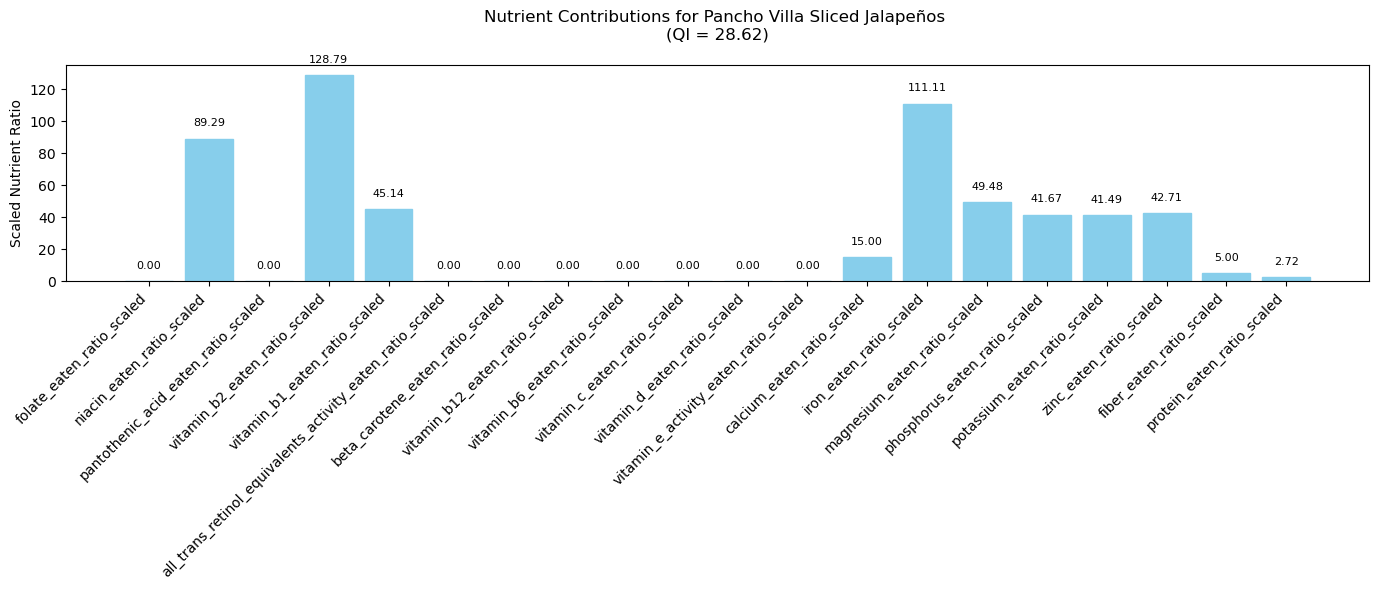

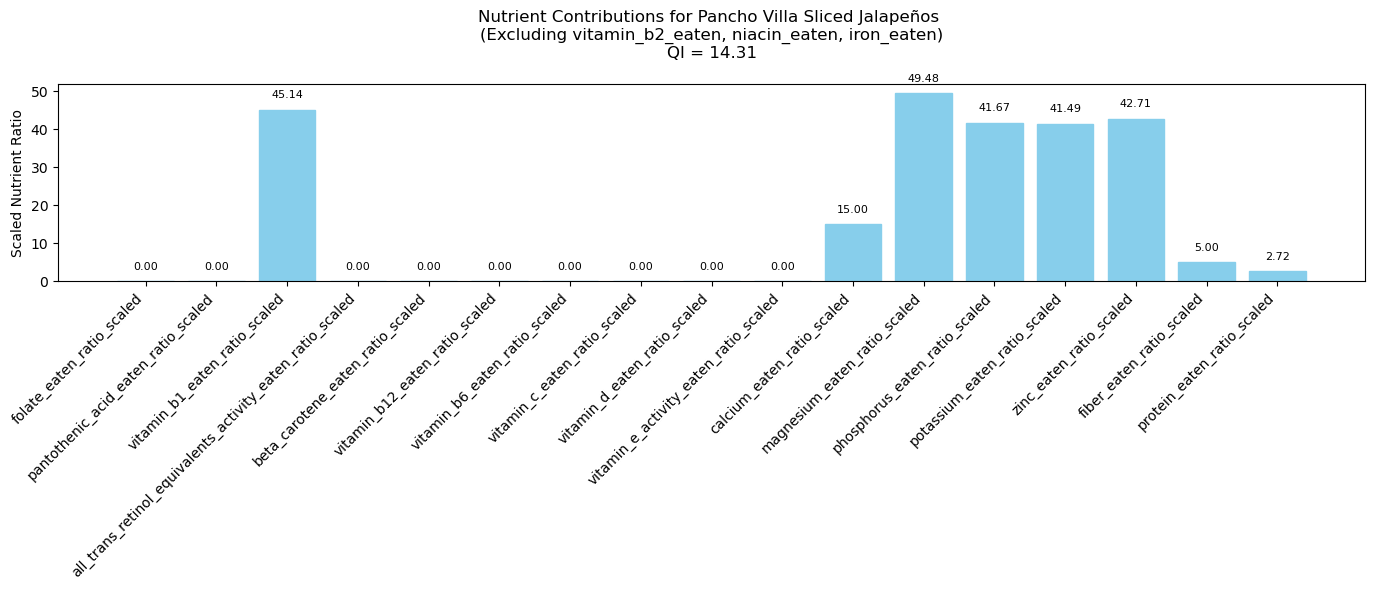

,Nutrient Excluded,QI (incl.),QI (excl.),Absolute Change,Percent Change
3,vitamin_b2_eaten,28.619226,23.347191,5.272034,18.421303
13,iron_eaten,28.619226,24.277547,4.341678,15.170495
1,niacin_eaten,28.619226,25.426253,3.192973,11.156742
14,magnesium_eaten,28.619226,27.521334,1.097892,3.836203
4,vitamin_b1_eaten,28.619226,27.749770,0.869456,3.038014
17,zinc_eaten,28.619226,27.877694,0.741532,2.591027
15,phosphorus_eaten,28.619226,27.932518,0.686707,2.399462
16,potassium_eaten,28.619226,27.941850,0.677376,2.366855
12,calcium_eaten,28.619226,29.336027,-0.716801,-2.504615
18,fiber_eaten,28.619226,29.862343,-1.243117,-4.343644


In [ ]:
food_item = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Pancho Villa Sliced Jalapeños'].iloc[0]

plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients)
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['vitamin_b2_eaten', 'niacin_eaten', 'iron_eaten'])

qi_including = food_item['QI']
results = []

for nutr in qualifying_nutrients:
    qi_excluding = compute_qi_excluding(food_item, qualifying_nutrients, exclude=nutr, scaling_factor=2000)
    abs_diff = qi_including - qi_excluding
    pct_diff = (abs_diff / qi_including) * 100
    results.append({
        'Nutrient Excluded': nutr,
        'QI (incl.)': qi_including,
        'QI (excl.)': qi_excluding,
        'Absolute Change': abs_diff,
        'Percent Change': pct_diff
    })


df_results = pd.DataFrame(results)
df_results.sort_values('Absolute Change', ascending=False)